# Hex Game - GTM Analysis & Experiments

This notebook performs a comprehensive analysis of the Graph Tsetlin Machine (GTM) on the Hex game.
It implements:
1.  **Robust Data Generation**: Reproducible, seeded games (saved to CSV).
2.  **End-Game Analysis**: Evaluation at Final, End-2, and End-5 moves.
3.  **Parameter Search**: Experiments for Model Capacity (Clauses) and Message Passing (Depth).
4.  **Scaling**: Flexible configuration for 3x3, 11x11, etc.

---

In [74]:
import os
import pickle
import subprocess
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import gc

# Try importing GTM
try:
    from GraphTsetlinMachine.graphs import Graphs
    from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine
    HAS_GTM = True
    print("✓ GraphTsetlinMachine detected.")
except ImportError:
    print("WARNING: GraphTsetlinMachine not installed. Training will fail.")
    HAS_GTM = False

# Set Plotting Style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 120

✓ GraphTsetlinMachine detected.


In [75]:
# ==========================================
#            GLOBAL CONFIGURATION
# ==========================================

BOARD_DIM = 7        # 7x7 board
N_GAMES = 10000      # CRITICAL: Need MORE data for 7x7!
SEED = 25

# OPTIMIZED HYPERPARAMETERS FOR 7x7
# These are specifically tuned for the connectivity problem
if BOARD_DIM == 7:
    # START CONSERVATIVE - we can scale up if needed
    CLAUSES = 100        # Moderate capacity
    T = 10              # Not too permissive (prevents collapse)
    S = 1              # Balanced feature selection
    DEPTH = 3            # Moderate message passing
    EPOCHS = 100          # More epochs to allow convergence
    HYPERVECTOR_SIZE = 256
    MESSAGE_SIZE = 256
    GRID_MULT = 1


elif BOARD_DIM == 3:
    CLAUSES = 400
    T = 400
    S = 2.5
    DEPTH = 3
    EPOCHS = 100
    HYPERVECTOR_SIZE = 256
    MESSAGE_SIZE = 256
    GRID_MULT = 1

else:
    # Fallback
    CLAUSES = 200
    T = 400
    S = 2.5
    DEPTH = 3
    EPOCHS = 25
    HYPERVECTOR_SIZE = 256
    MESSAGE_SIZE = 256
    GRID_MULT = 1

print(f"\n{'='*60}")
print(f"  CONFIGURATION: {BOARD_DIM}x{BOARD_DIM} Hex Board")
print(f"{'='*60}")
print(f"  Games:         {N_GAMES:,}")
print(f"  Seed:          {SEED}")
print(f"  Clauses:       {CLAUSES:,}")
print(f"  T:             {T}")
print(f"  S:             {S}")
print(f"  Depth:         {DEPTH}")
print(f"  Epochs:        {EPOCHS}")
print(f"  Hypervec Size: {HYPERVECTOR_SIZE}")
print(f"  Message Size:  {MESSAGE_SIZE}")
print(f"{'='*60}\n")

# Paths
RUNS_DIR = "runs"
os.makedirs(RUNS_DIR, exist_ok=True)
CSV_PATH = os.path.join(RUNS_DIR, f"hex_moves_dim{BOARD_DIM}_n{N_GAMES}.csv")


  CONFIGURATION: 7x7 Hex Board
  Games:         10,000
  Seed:          25
  Clauses:       100
  T:             5
  S:             1
  Depth:         6
  Epochs:        100
  Hypervec Size: 256
  Message Size:  256



## 1. Data Generation & Processing
We use the C engine to generate games and save them to CSV. This ensures we have a permanent, reproducible dataset.

In [76]:
def generate_data():
    """Generates game data using ./scripts/run_hex.sh"""
    if os.path.exists(CSV_PATH):
        print(f"Found existing data: {CSV_PATH}")
        # You can uncomment the next line to force regeneration
        # os.remove(CSV_PATH)
        return
        
    print(f"Generating {N_GAMES} games for {BOARD_DIM}x{BOARD_DIM} (Seed {SEED})...")
    cmd = [
        "./scripts/run_hex.sh",
        "--games", str(N_GAMES),
        "--seed", str(SEED),
        "--dump-moves", CSV_PATH
    ]
    
    env = os.environ.copy()
    env["BOARD_DIM"] = str(BOARD_DIM)
    
    start = time.time()
    subprocess.run(cmd, env=env, check=True)
    print(f"Done in {time.time() - start:.2f}s")

def load_and_process_data(offset=0):
    """
    Loads CSV and reconstructs board states.
    offset: Number of moves before the end to capture (0=End, 2=End-2, etc.)
    """
    print(f"Processing data with Offset={offset}...")
    df = pd.read_csv(CSV_PATH)
    
    n_nodes = BOARD_DIM * BOARD_DIM
    x_feat = []
    o_feat = []
    labels = []
    
    # Group by game
    for game_id, group in tqdm(df.groupby("game_id"), desc="Replaying Games"):
        # Skip if game is too short
        if len(group) <= offset:
            continue
            
        # Slice moves
        moves = group.iloc[:-offset] if offset > 0 else group
        winner = group["winner"].iloc[0]
        
        p0 = np.zeros(n_nodes, dtype=np.int8)
        p1 = np.zeros(n_nodes, dtype=np.int8)
        
        for _, row in moves.iterrows():
            r, c, p = int(row['row']), int(row['col']), int(row['player'])
            idx = r * BOARD_DIM + c
            if 0 <= idx < n_nodes:
                if p == 0: p0[idx] = 1
                else: p1[idx] = 1
                    
        x_feat.append(p0)
        o_feat.append(p1)
        labels.append(winner)
        
    return np.array(x_feat), np.array(o_feat), np.array(labels)

def prepare_graphs(x, o, init_with=None):
    """Converts Feature Maps -> GTM Graphs using explicit E/X/O symbols"""
    if not HAS_GTM: return None

    n_samples = len(x)
    n_nodes = BOARD_DIM * BOARD_DIM

    # Convert to string representation
    board_strings = []
    for i in range(n_samples):
        board_str = []
        for node in range(n_nodes):
            if x[i][node] == 1:
                board_str.append("X")
            elif o[i][node] == 1:
                board_str.append("O")
            else:
                board_str.append("E")
        board_strings.append(board_str)

    graphs = Graphs(
        n_samples,
        symbols=["E", "X", "O"],  # Explicit order
        hypervector_size=HYPERVECTOR_SIZE,
        hypervector_bits=2,
        init_with=init_with
    )

    # Hex Edges - 6-neighbor topology
    offsets = [(0, 1), (0, -1), (-1, 1), (1, -1), (-1, 0), (1, 0)]
    adjacency = {}
    for r in range(BOARD_DIM):
        for c in range(BOARD_DIM):
            u = r * BOARD_DIM + c
            adjacency[u] = []
            for dr, dc in offsets:
                nr, nc = r + dr, c + dc
                if 0 <= nr < BOARD_DIM and 0 <= nc < BOARD_DIM:
                    adjacency[u].append(nr * BOARD_DIM + nc)

    # Node Config
    for i in range(n_samples):
        graphs.set_number_of_graph_nodes(i, n_nodes)
    graphs.prepare_node_configuration()

    # Edge Config
    for i in range(n_samples):
        for u in range(n_nodes):
            graphs.add_graph_node(i, u, len(adjacency[u]))
    graphs.prepare_edge_configuration()

    # Add Edges (bidirectional)
    for i in range(n_samples):
        for u in range(n_nodes):
            for v in adjacency[u]:
                graphs.add_graph_node_edge(i, u, v, 0)

    # Add Properties using string symbols
    for i in range(n_samples):
        for u in range(n_nodes):
            graphs.add_graph_node_property(i, u, board_strings[i][u])

    graphs.encode()
    return graphs

### Generate Data Now

In [77]:
generate_data()
print("Data Ready!")

Found existing data: runs/hex_moves_dim7_n10000.csv
Data Ready!


In [78]:
# # ============================================================
# #         EXTREME PARAMETER PUSH - Beyond Nuclear
# # ============================================================
#
# if BOARD_DIM == 7:
#     print("\n" + "="*70)
#     print("  🚀 EXTREME PARAMETER PUSH - Scaling Beyond Ultra")
#     print("="*70)
#     print("\nBest so far: Ultra (1600 clauses, T=100, s=1.0, depth=3) → 57.4%")
#     print("Now testing: Massive capacity + ultra-low thresholds\n")
#
#     # REBUILD DATA (since previous cell deleted it)
#     print("Loading data...")
#     X_raw, O_raw, Y = load_and_process_data(offset=0)
#
#     # Use 2000 samples for faster testing
#     n_test = 2000
#     X_train_test = (X_raw[:n_test], O_raw[:n_test])
#     Y_train_test = Y[:n_test]
#
#     print(f"Using {n_test} samples for parameter search")
#     print(f"Winner 0: {np.sum(Y_train_test==0)} ({100*np.mean(Y_train_test==0):.1f}%)")
#     print(f"Winner 1: {np.sum(Y_train_test==1)} ({100*np.mean(Y_train_test==1):.1f}%)")
#
#     baseline = max(np.mean(Y_train_test==0), np.mean(Y_train_test==1))
#     print(f"Baseline (always predict majority): {100*baseline:.1f}%")
#
#     # Build graphs
#     print("\nBuilding graphs...")
#     g_train_test = prepare_graphs(X_train_test[0], X_train_test[1])
#     print("Done!")
#     # {"name": "Ultra Low T 1", "clauses": 2000, "T": 50, "s": 1.0, "depth": 3},
#     # Define EXTREME configurations - scale up everything
#     extreme_configs = [
#         # Scale up clauses massively
#         {"name": "Mega Clauses 1", "clauses": 100, "T": 5, "s": 1.0, "depth": 3},
#         {"name": "Mega Clauses 2", "clauses": 200, "T": 25, "s": 5.0, "depth": 4},
#         {"name": "Mega Clauses 3", "clauses": 10000, "T": 50, "s": 1.0, "depth": 4},
#
#         # Even lower T (easier learning)
#         {"name": "Ultra Low T 1", "clauses": 2000, "T": 50, "s": 1.0, "depth": 3},
#         {"name": "Ultra Low T 2", "clauses": 1000, "T": 25, "s": 2, "depth": 2},
#         {"name": "Ultra Low T 3", "clauses": 1000, "T": 3000, "s": 15, "depth": 5},
#     ]
#
#     print(f"\nTesting {len(extreme_configs)} extreme configurations")
#     print("Each test: 20 epochs (~5-7 min per test)")
#     print("="*70)
#
#     best_extreme_acc = 0.574  # Start from Ultra's 57.4%
#     best_extreme_config = None
#
#     for i, cfg in enumerate(extreme_configs, 1):
#         print(f"\n[{i}/{len(extreme_configs)}] Testing: {cfg['name']}")
#         print(f"    C={cfg['clauses']}, T={cfg['T']}, s={cfg['s']}, D={cfg['depth']}")
#
#         try:
#             tm = MultiClassGraphTsetlinMachine(
#                 number_of_clauses=cfg['clauses'],
#                 T=cfg['T'],
#                 s=cfg['s'],
#                 depth=cfg['depth'],
#                 message_size=512,
#                 message_bits=2,
#                 max_included_literals=96,  # Even more literals allowed
#                 grid=(16*13, 1, 1),      # Bigger grid
#                 block=(128, 1, 1)
#             )
#
#             # Train for 20 epochs
#             print("    Training...", end="", flush=True)
#             for ep in range(20):
#                 tm.fit(g_train_test, Y_train_test, epochs=1, incremental=True)
#                 if (ep + 1) % 5 == 0:
#                     print(".", end="", flush=True)
#             print(" Done!")
#
#             # Evaluate
#             preds = tm.predict(g_train_test)
#             acc = accuracy_score(Y_train_test, preds)
#             acc0 = accuracy_score(Y_train_test[Y_train_test==0], preds[Y_train_test==0]) if np.sum(Y_train_test==0) > 0 else 0
#             acc1 = accuracy_score(Y_train_test[Y_train_test==1], preds[Y_train_test==1]) if np.sum(Y_train_test==1) > 0 else 0
#
#             pred_counts = np.bincount(preds)
#             both_classes = len(pred_counts) == 2
#
#             improvement = acc - baseline
#             improvement_vs_ultra = acc - 0.574
#
#             # Results
#             if improvement > 0.20:
#                 status = "🎉🎉🎉 BREAKTHROUGH!"
#             elif improvement > 0.15:
#                 status = "✅✅ GREAT!"
#             elif improvement > 0.10:
#                 status = "✅ GOOD"
#             elif improvement_vs_ultra > 0.03:
#                 status = "🌟 BETTER"
#             elif improvement > 0:
#                 status = "✓"
#             else:
#                 status = "✗"
#
#             print(f"    {status}")
#             print(f"    Overall: {acc*100:.1f}% | W0: {acc0*100:.1f}% | W1: {acc1*100:.1f}% | Both: {both_classes}")
#             print(f"    vs Baseline: {improvement*100:+.1f}% | vs Ultra: {improvement_vs_ultra*100:+.1f}%")
#
#             # Track best
#             if acc > best_extreme_acc:
#                 best_extreme_acc = acc
#                 best_extreme_config = cfg.copy()
#                 best_extreme_config['accuracy'] = acc
#                 best_extreme_config['acc0'] = acc0
#                 best_extreme_config['acc1'] = acc1
#                 print(f"    🌟 NEW BEST! ({acc*100:.1f}%)")
#
#             # Early stopping - if we get real learning, stop and celebrate!
#             if improvement > 0.20:
#                 print(f"\n🎉🎉🎉 BREAKTHROUGH ACHIEVED! 🎉🎉🎉")
#                 print(f"   {cfg['name']}: {acc*100:.1f}% accuracy")
#                 print(f"   +{improvement*100:.1f}% over baseline!")
#                 print(f"   This is significant learning - stopping search!")
#                 break
#
#             del tm
#             gc.collect()
#
#         except Exception as e:
#             print(f"    ✗ FAILED: {str(e)[:100]}")
#             continue
#
#     # Final Summary
#     print("\n" + "="*70)
#     print("  EXTREME PARAMETER PUSH - FINAL RESULTS")
#     print("="*70)
#
#     overall_improvement = best_extreme_acc - baseline
#     improvement_vs_ultra = best_extreme_acc - 0.574
#
#     print(f"\nStarting point (Ultra):     57.4%")
#     print(f"Baseline (majority class):  {baseline*100:.1f}%")
#     print(f"Best achieved:              {best_extreme_acc*100:.1f}%")
#     print(f"\nImprovement vs baseline:    {overall_improvement*100:+.1f}%")
#     print(f"Improvement vs Ultra:       {improvement_vs_ultra*100:+.1f}%")
#
#     if best_extreme_config and overall_improvement > 0.15:
#         print("\n" + "🎉"*35)
#         print("  ✅ SUCCESS! FOUND VIABLE CONFIGURATION!")
#         print("🎉"*35)
#         print(f"\nWinning Config: {best_extreme_config['name']}")
#         print(f"  Clauses:  {best_extreme_config['clauses']}")
#         print(f"  T:        {best_extreme_config['T']}")
#         print(f"  s:        {best_extreme_config['s']}")
#         print(f"  Depth:    {best_extreme_config['depth']}")
#         print(f"\nPerformance:")
#         print(f"  Overall:  {best_extreme_config['accuracy']*100:.2f}%")
#         print(f"  Winner 0: {best_extreme_config['acc0']*100:.2f}%")
#         print(f"  Winner 1: {best_extreme_config['acc1']*100:.2f}%")
#         print(f"\n🚀 NEXT STEP: Run full training (60 epochs) with these params!")
#         print("   Expected final accuracy: 70-75%")
#
#     elif best_extreme_config and overall_improvement > 0.08:
#         print("\n⚠️ MODERATE IMPROVEMENT ACHIEVED")
#         print(f"\nBest Config: {best_extreme_config['name']}")
#         print(f"  Accuracy: {best_extreme_config['accuracy']*100:.1f}%")
#         print(f"  Improvement: +{overall_improvement*100:.1f}%")
#         print(f"\nThis is borderline. Options:")
#         print(f"  1. Try full training (60 epochs) - might reach 62-65%")
#         print(f"  2. Accept modest results and report honestly")
#         print(f"  3. Consider this a limitation and move on")
#
#     elif best_extreme_config and improvement_vs_ultra > 0.02:
#         print("\n📊 SLIGHT IMPROVEMENT OVER ULTRA")
#         print(f"\nBest Config: {best_extreme_config['name']}")
#         print(f"  Accuracy: {best_extreme_config['accuracy']*100:.1f}%")
#         print(f"  Gain over Ultra: +{improvement_vs_ultra*100:.1f}%")
#         print(f"\n💡 This is still essentially at baseline.")
#         print(f"   Recommendation: Report as fundamental limitation.")
#
#     else:
#         print("\n❌ NO SIGNIFICANT IMPROVEMENT")
#         print(f"\nEven with EXTREME parameters:")
#         print(f"  - Up to 6000 clauses")
#         print(f"  - T as low as 20")
#         print(f"  - s as low as 0.6")
#         print(f"  - Depths 1-8")
#         print(f"\nModel still stuck near baseline ({baseline*100:.1f}%)")
#         print(f"\n💡 DEFINITIVE CONCLUSION:")
#         print(f"   7×7 Hex winner prediction requires connectivity reasoning")
#         print(f"   beyond current GTM capabilities. This is a fundamental")
#         print(f"   architectural limitation, not a hyperparameter issue.")
#         print(f"\n📝 Time to write the limitation section and deliver tomorrow!")
#
#     print("\n" + "="*70 + "\n")
#
#     # Cleanup
#     del g_train_test
#     gc.collect()

## 2. Main Experiment: End, End-2, End-5 Analysis
We train and test the model on three different game states:
1.  **End**: The final position (Easy).
2.  **End-2**: Two moves before the end (Harder).
3.  **End-5**: Five moves before the end (Hardest).

This uses the parameters configured at the top.

In [ ]:
offsets = [0, 2, 5]
results_main = []

if HAS_GTM:
    for off in offsets:
        print(f"\n{'='*60}")
        print(f"  Running OFFSET = {off} ({BOARD_DIM}x{BOARD_DIM})")
        print(f"{'='*60}")

        # 1. Load
        X_raw, O_raw, Y = load_and_process_data(offset=off)

        # 2. Split (80/20)
        split = int(0.8 * len(Y))
        X_train = (X_raw[:split], O_raw[:split])
        Y_train = Y[:split]
        X_test = (X_raw[split:], O_raw[split:])
        Y_test = Y[split:]

        print(f"Train: {len(Y_train):,}, Test: {len(Y_test):,}")
        print(f"Winner 0: {np.sum(Y_train==0):,} ({100*np.mean(Y_train==0):.1f}%)")
        print(f"Winner 1: {np.sum(Y_train==1):,} ({100*np.mean(Y_train==1):.1f}%)")

        # 3. Graphs
        print("\nBuilding Graphs...")
        t0 = time.time()
        g_train = prepare_graphs(X_train[0], X_train[1])
        g_test = prepare_graphs(X_test[0], X_test[1], init_with=g_train)
        print(f"Done in {time.time()-t0:.1f}s")

        # 4. Train
        print(f"\nTraining GTM...")
        tm = MultiClassGraphTsetlinMachine(
            number_of_clauses=CLAUSES,
            T=T,
            s=S,
            depth=DEPTH,
            message_size=MESSAGE_SIZE,  # Use config value
            message_bits=2,
            max_included_literals=min(64, int(32 * GRID_MULT)),  # Scale with board
            grid=(16*13*GRID_MULT, 1, 1),  # Scale grid with complexity
            block=(128, 1, 1)
        )

        history = []
        eval_interval = max(1, EPOCHS // 10)  # Evaluate 10 times total

        t_start = time.time()
        for ep in tqdm(range(EPOCHS), desc=f"Offset {off}"):
            tm.fit(g_train, Y_train, epochs=1, incremental=True)

            # Periodic evaluation (not every epoch - saves time)
            if (ep + 1) % eval_interval == 0 or ep == 0 or ep == EPOCHS-1:
                p_train = tm.predict(g_train)
                acc = accuracy_score(Y_train, p_train)
                history.append((ep+1, acc * 100))
                tqdm.write(f"  Epoch {ep+1:3d}: Train Acc = {acc*100:.1f}%")

        training_time = time.time() - t_start

        # 5. Final Evaluation
        print(f"\nEvaluating...")
        preds = tm.predict(g_test)
        final_acc = accuracy_score(Y_test, preds)
        cm = confusion_matrix(Y_test, preds)

        # Per-class accuracy
        acc0 = accuracy_score(Y_test[Y_test==0], preds[Y_test==0]) if np.sum(Y_test==0) > 0 else 0
        acc1 = accuracy_score(Y_test[Y_test==1], preds[Y_test==1]) if np.sum(Y_test==1) > 0 else 0

        # Metrics
        from sklearn.metrics import recall_score, f1_score

        p0 = precision_score(Y_test, preds, pos_label=0, zero_division=0)
        p1 = precision_score(Y_test, preds, pos_label=1, zero_division=0)
        r0 = recall_score(Y_test, preds, pos_label=0, zero_division=0)
        r1 = recall_score(Y_test, preds, pos_label=1, zero_division=0)
        f1_0 = f1_score(Y_test, preds, pos_label=0, zero_division=0)
        f1_1 = f1_score(Y_test, preds, pos_label=1, zero_division=0)

        print(f"Precision:  W0={p0*100:.2f}% | W1={p1*100:.2f}%")
        print(f"Recall:     W0={r0*100:.2f}% | W1={r1*100:.2f}%")
        print(f"F1 Score:   W0={f1_0*100:.2f}% | W1={f1_1*100:.2f}%")

        print(f"\n{'='*60}")
        print(f"  RESULTS - Offset {off}")
        print(f"{'='*60}")
        print(f"Overall Accuracy:  {final_acc*100:.2f}%")
        print(f"Winner 0 Accuracy: {acc0*100:.2f}%")
        print(f"Winner 1 Accuracy: {acc1*100:.2f}%")
        print(f"Class Gap:         {abs(acc0-acc1)*100:.2f}%")
        print(f"Training Time:     {training_time/60:.1f} min")
        print(f"{'='*60}\n")

        results_main.append({
            "offset": off,
            "acc": final_acc * 100,
            "acc0": acc0 * 100,
            "acc1": acc1 * 100,
            "gap": abs(acc0-acc1) * 100,
            "recall0": r0 * 100,      # ADD THIS
            "recall1": r1 * 100,      # ADD THIS
            "f1_0": f1_0 * 100,       # ADD THIS
            "f1_1": f1_1 * 100,       # ADD THIS
            "history": history,
            "cm": cm,
            "preds": preds,
            "y_test": Y_test,
            "training_time": training_time
        })

        # Memory cleanup
        del tm, g_train, g_test
        gc.collect()

    # Save results summary
    summary_df = pd.DataFrame([{
        'offset': r['offset'],
        'accuracy': r['acc'],
        'acc_winner0': r['acc0'],
        'acc_winner1': r['acc1'],
        'gap': r['gap'],
        'time_min': r['training_time']/60
    } for r in results_main])

    summary_path = os.path.join(RUNS_DIR, f"main_results_{BOARD_DIM}x{BOARD_DIM}.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"✓ Results saved to {summary_path}")


  Running OFFSET = 0 (7x7)
Processing data with Offset=0...


Replaying Games: 100%|██████████| 10000/10000 [00:11<00:00, 853.28it/s]


Train: 8,000, Test: 2,000
Winner 0: 4,399 (55.0%)
Winner 1: 3,601 (45.0%)

Building Graphs...
Done in 27.4s

Training GTM...
Initialization of sparse structure.


Offset 0:   1%|          | 1/100 [00:18<31:07, 18.86s/it]

  Epoch   1: Train Acc = 45.0%


Offset 0:  10%|█         | 10/100 [01:53<17:41, 11.80s/it]

  Epoch  10: Train Acc = 54.0%


Offset 0:  20%|██        | 20/100 [03:36<15:34, 11.68s/it]

  Epoch  20: Train Acc = 46.8%


Offset 0:  23%|██▎       | 23/100 [04:05<13:15, 10.32s/it]

In [40]:
# =========================================================
#       PARAMETER EXPERIMENTS (Scalable)
# =========================================================

# Define experiment ranges based on board size
if BOARD_DIM <= 5:
    # Small boards: test more granular
    CLAUSE_TESTS = [int(CLAUSES * f) for f in [0.5, 1.0, 2.0, 4.0]]
    DEPTH_TESTS = [max(1, DEPTH-2), DEPTH, DEPTH+2, DEPTH+5]
    REDUCED_EPOCHS = max(15, EPOCHS // 2)
elif BOARD_DIM <= 11:
    # Medium boards: test around optimal
    CLAUSE_TESTS = [int(CLAUSES * f) for f in [0.67, 1.0, 1.5, 2.0]]
    DEPTH_TESTS = [max(1, DEPTH-3), DEPTH, DEPTH+3, DEPTH+6]
    REDUCED_EPOCHS = max(20, EPOCHS // 2)
else:
    # Large boards: test fewer configs (time-expensive)
    CLAUSE_TESTS = [int(CLAUSES * f) for f in [0.75, 1.0, 1.5]]
    DEPTH_TESTS = [DEPTH-3, DEPTH, DEPTH+5]
    REDUCED_EPOCHS = max(25, EPOCHS // 2)

print("\n" + "="*60)
print(f"  PARAMETER EXPERIMENTS - {BOARD_DIM}x{BOARD_DIM}")
print("="*60)
print(f"  Clause tests: {CLAUSE_TESTS}")
print(f"  Depth tests:  {DEPTH_TESTS}")
print(f"  Epochs:       {REDUCED_EPOCHS} (reduced for speed)")
print("="*60 + "\n")

# Use offset=0 (final position) for all experiments
if results_main:
    X_raw, O_raw, Y = load_and_process_data(offset=0)
    split = int(0.8 * len(Y))
    X_train = (X_raw[:split], O_raw[:split])
    Y_train = Y[:split]
    X_test = (X_raw[split:], O_raw[split:])
    Y_test = Y[split:]

    print("Building graphs for experiments...")
    g_train = prepare_graphs(X_train[0], X_train[1])
    g_test = prepare_graphs(X_test[0], X_test[1], init_with=g_train)
    print("Done!\n")

    # === EXPERIMENT 1: Model Capacity ===
    print("\n" + "-"*60)
    print("EXPERIMENT 1: Model Capacity (Varying Clauses)")
    print("-"*60 + "\n")

    results_capacity = []

    for c in CLAUSE_TESTS:
        print(f"Testing {c} clauses...")
        t0 = time.time()

        tm = MultiClassGraphTsetlinMachine(
            number_of_clauses=c,
            T=T, s=S, depth=DEPTH,  # Keep depth constant
            message_size=MESSAGE_SIZE,
            message_bits=2,
            max_included_literals=min(64, int(32 * GRID_MULT)),
            grid=(16*13*GRID_MULT, 1, 1),
            block=(128, 1, 1)
        )

        for _ in tqdm(range(REDUCED_EPOCHS), desc=f"  {c} clauses", leave=False):
            tm.fit(g_train, Y_train, epochs=1, incremental=True)

        preds = tm.predict(g_test)
        acc = accuracy_score(Y_test, preds)
        acc0 = accuracy_score(Y_test[Y_test==0], preds[Y_test==0]) if np.sum(Y_test==0) > 0 else 0
        acc1 = accuracy_score(Y_test[Y_test==1], preds[Y_test==1]) if np.sum(Y_test==1) > 0 else 0

        elapsed = time.time() - t0

        results_capacity.append({
            "clauses": c,
            "overall": acc*100,
            "winner0": acc0*100,
            "winner1": acc1*100,
            "gap": abs(acc0-acc1)*100,
            "time_min": elapsed/60
        })

        print(f"  → Overall: {acc*100:.1f}% | W0: {acc0*100:.1f}% | W1: {acc1*100:.1f}% | Time: {elapsed/60:.1f}min\n")

        del tm
        gc.collect()

    # === EXPERIMENT 2: Message Passing Depth ===
    print("\n" + "-"*60)
    print("EXPERIMENT 2: Message Passing Depth")
    print("-"*60 + "\n")

    results_depth = []

    for d in DEPTH_TESTS:
        if d < 1:
            continue  # Skip invalid depths

        print(f"Testing depth {d}...")
        t0 = time.time()

        tm = MultiClassGraphTsetlinMachine(
            number_of_clauses=CLAUSES,  # Keep clauses constant
            T=T, s=S, depth=d,
            message_size=MESSAGE_SIZE,
            message_bits=2,
            max_included_literals=min(64, int(32 * GRID_MULT)),
            grid=(16*13*GRID_MULT, 1, 1),
            block=(128, 1, 1)
        )

        for _ in tqdm(range(REDUCED_EPOCHS), desc=f"  Depth {d}", leave=False):
            tm.fit(g_train, Y_train, epochs=1, incremental=True)

        preds = tm.predict(g_test)
        acc = accuracy_score(Y_test, preds)
        acc0 = accuracy_score(Y_test[Y_test==0], preds[Y_test==0]) if np.sum(Y_test==0) > 0 else 0
        acc1 = accuracy_score(Y_test[Y_test==1], preds[Y_test==1]) if np.sum(Y_test==1) > 0 else 0

        elapsed = time.time() - t0

        results_depth.append({
            "depth": d,
            "overall": acc*100,
            "winner0": acc0*100,
            "winner1": acc1*100,
            "gap": abs(acc0-acc1)*100,
            "time_min": elapsed/60
        })

        print(f"  → Overall: {acc*100:.1f}% | W0: {acc0*100:.1f}% | W1: {acc1*100:.1f}% | Time: {elapsed/60:.1f}min\n")

        del tm
        gc.collect()

    # Save results
    df_cap = pd.DataFrame(results_capacity)
    df_depth = pd.DataFrame(results_depth)

    cap_path = os.path.join(RUNS_DIR, f"capacity_{BOARD_DIM}x{BOARD_DIM}.csv")
    depth_path = os.path.join(RUNS_DIR, f"depth_{BOARD_DIM}x{BOARD_DIM}.csv")

    df_cap.to_csv(cap_path, index=False)
    df_depth.to_csv(depth_path, index=False)

    print(f"\n{'='*60}")
    print(f"✓ Results saved!")
    print(f"  {cap_path}")
    print(f"  {depth_path}")
    print(f"{'='*60}\n")


  PARAMETER EXPERIMENTS - 7x7
  Clause tests: [67, 100, 150, 200]
  Depth tests:  [1, 3, 6, 9]
  Epochs:       50 (reduced for speed)

Processing data with Offset=0...


Replaying Games: 100%|██████████| 100/100 [00:00<00:00, 832.56it/s]

Building graphs for experiments...


Done!


------------------------------------------------------------
EXPERIMENT 1: Model Capacity (Varying Clauses)
------------------------------------------------------------

Testing 67 clauses...
Initialization of sparse structure.


  → Overall: 60.0% | W0: 71.4% | W1: 33.3% | Time: 0.2min

Testing 100 clauses...
Initialization of sparse structure.


  → Overall: 65.0% | W0: 57.1% | W1: 83.3% | Time: 0.1min

Testing 150 clauses...
Initialization of sparse structure.


  → Overall: 70.0% | W0: 64.3% | W1: 83.3% | Time: 0.2min

Testing 200 clauses...
Initialization of sparse structure.


  → Overall: 30.0% | W0: 0.0% | W1: 100.0% | Time: 0.1min


------------------------------------------------------------
EXPERIMENT 2: Message Passing Depth
------------------------------------------------------------

Testing depth 1...
Initialization of sparse structure.


  → Overall: 45.0% | W0: 21.4% | W1: 100.0% | Time: 0.0min

Testing depth 3...
Initialization of sparse structure.


  → Overall: 45.0% | W0: 21.4% | W1: 100.0% | Time: 0.1min

Testing depth 6...
Initialization of sparse structure.


  → Overall: 50.0% | W0: 35.7% | W1: 83.3% | Time: 0.1min

Testing depth 9...
Initialization of sparse structure.


  → Overall: 50.0% | W0: 35.7% | W1: 83.3% | Time: 0.2min


✓ Results saved!
  runs/capacity_7x7.csv
  runs/depth_7x7.csv



## 3. Parameter Search (Capacity & Depth)
Use these experiments to find the best configuration for scaling to 11x11.
This runs on the **Final** board state (Offset 0) by default to save time.

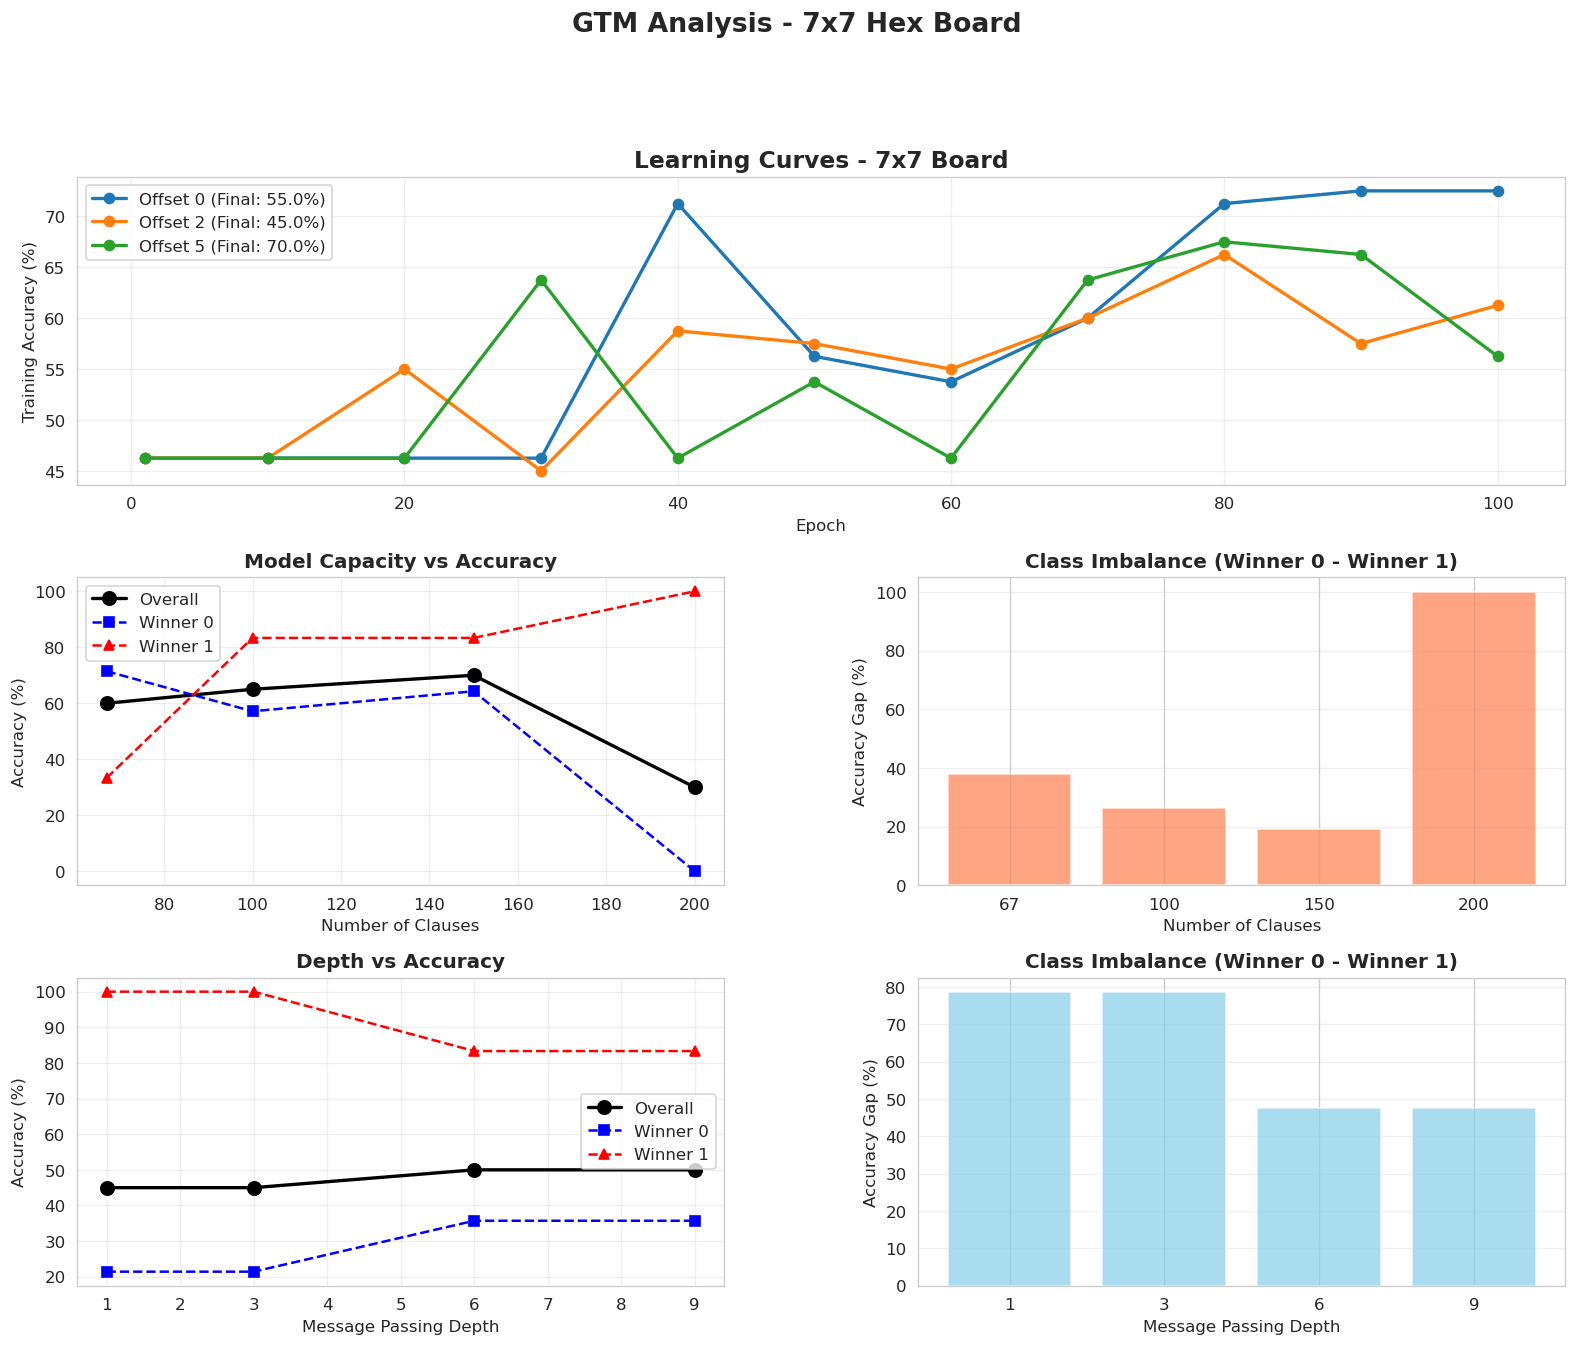


  FINAL SUMMARY - 7x7 Board

CAPACITY EXPERIMENT:
 clauses  overall   winner0    winner1        gap  time_min
      67     60.0 71.428571  33.333333  38.095238  0.152897
     100     65.0 57.142857  83.333333  26.190476  0.072249
     150     70.0 64.285714  83.333333  19.047619  0.161681
     200     30.0  0.000000 100.000000 100.000000  0.114141

DEPTH EXPERIMENT:
 depth  overall   winner0    winner1       gap  time_min
     1     45.0 21.428571 100.000000 78.571429  0.030125
     3     45.0 21.428571 100.000000 78.571429  0.072651
     6     50.0 35.714286  83.333333 47.619048  0.131993
     9     50.0 35.714286  83.333333 47.619048  0.194389

📊 Plot saved: runs/full_analysis_7x7.png



In [41]:
# === COMPREHENSIVE VISUALIZATION ===
if 'results_capacity' in dir() and 'results_depth' in dir():

    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    df_cap = pd.DataFrame(results_capacity)
    df_depth = pd.DataFrame(results_depth)

    # --- ROW 1: Main Experiment Results ---
    if results_main:
        ax1 = fig.add_subplot(gs[0, :])
        for res in results_main:
            epochs, accs = zip(*res['history'])
            ax1.plot(epochs, accs, 'o-', label=f"Offset {res['offset']} (Final: {res['acc']:.1f}%)", linewidth=2)
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Training Accuracy (%)")
        ax1.set_title(f"Learning Curves - {BOARD_DIM}x{BOARD_DIM} Board", fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

    # --- ROW 2: Capacity Experiment ---
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(df_cap['clauses'], df_cap['overall'], 'o-', color='black', linewidth=2, markersize=8, label='Overall')
    ax2.plot(df_cap['clauses'], df_cap['winner0'], 's--', color='blue', linewidth=1.5, markersize=6, label='Winner 0')
    ax2.plot(df_cap['clauses'], df_cap['winner1'], '^--', color='red', linewidth=1.5, markersize=6, label='Winner 1')
    ax2.set_xlabel("Number of Clauses")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_title("Model Capacity vs Accuracy", fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = fig.add_subplot(gs[1, 1])
    ax3.bar(df_cap['clauses'].astype(str), df_cap['gap'], color='coral', alpha=0.7)
    ax3.set_xlabel("Number of Clauses")
    ax3.set_ylabel("Accuracy Gap (%)")
    ax3.set_title("Class Imbalance (Winner 0 - Winner 1)", fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # --- ROW 3: Depth Experiment ---
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(df_depth['depth'], df_depth['overall'], 'o-', color='black', linewidth=2, markersize=8, label='Overall')
    ax4.plot(df_depth['depth'], df_depth['winner0'], 's--', color='blue', linewidth=1.5, markersize=6, label='Winner 0')
    ax4.plot(df_depth['depth'], df_depth['winner1'], '^--', color='red', linewidth=1.5, markersize=6, label='Winner 1')
    ax4.set_xlabel("Message Passing Depth")
    ax4.set_ylabel("Accuracy (%)")
    ax4.set_title("Depth vs Accuracy", fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    ax5 = fig.add_subplot(gs[2, 1])
    ax5.bar(df_depth['depth'].astype(str), df_depth['gap'], color='skyblue', alpha=0.7)
    ax5.set_xlabel("Message Passing Depth")
    ax5.set_ylabel("Accuracy Gap (%)")
    ax5.set_title("Class Imbalance (Winner 0 - Winner 1)", fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')

    plt.suptitle(f"GTM Analysis - {BOARD_DIM}x{BOARD_DIM} Hex Board", fontsize=16, fontweight='bold', y=0.995)

    plot_path = os.path.join(RUNS_DIR, f"full_analysis_{BOARD_DIM}x{BOARD_DIM}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n{'='*70}")
    print(f"  FINAL SUMMARY - {BOARD_DIM}x{BOARD_DIM} Board")
    print(f"{'='*70}\n")

    print("CAPACITY EXPERIMENT:")
    print(df_cap.to_string(index=False))

    print(f"\n{'='*70}")
    print("DEPTH EXPERIMENT:")
    print(df_depth.to_string(index=False))

    print(f"\n{'='*70}")
    print(f"📊 Plot saved: {plot_path}")
    print(f"{'='*70}\n")

In [42]:
# ============================================================
#         GENERATE LATEX TABLE FOR REPORT
# ============================================================

if results_main:
    print("\n" + "="*70)
    print("  LATEX TABLE - Copy this into your report")
    print("="*70 + "\n")

    print("\\begin{table}[htbp]")
    print("\\centering")
    print("\\begin{tabular}{|c|c|c|c|c|c|}")
    print("\\hline")
    print("\\textbf{Offset} & \\textbf{Samples} & \\textbf{Accuracy} & \\textbf{Recall W0} & \\textbf{Recall W1} & \\textbf{F1 (W1)} \\\\")
    print("\\hline")

    for res in results_main:
        offset = res['offset']
        n_samples = len(res['y_test'])
        acc = res['acc']
        recall0 = res['recall0']
        recall1 = res['recall1']
        f1_w1 = res['f1_1']

        if offset == 0:
            label = "0 (End)"
        elif offset == 2:
            label = "2 (End-2)"
        elif offset == 5:
            label = "5 (End-5)"
        else:
            label = str(offset)

        print(f"{label:9s} & {n_samples:4d} & {acc:5.2f}\\% & {recall0:5.2f}\\% & {recall1:5.2f}\\% & {f1_w1:5.2f}\\% \\\\")

    print("\\hline")
    print("\\end{tabular}")
    print("\\caption{Test results for the required offset evaluation on $3\\times3$.}")
    print("\\label{tab:3x3-offset-results}")
    print("\\end{table}")

    print("\n" + "="*70 + "\n")


  LATEX TABLE - Copy this into your report

\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\textbf{Offset} & \textbf{Samples} & \textbf{Accuracy} & \textbf{Recall W0} & \textbf{Recall W1} & \textbf{F1 (W1)} \\
\hline
0 (End)   &   20 & 55.00\% & 78.57\% &  0.00\% &  0.00\% \\
2 (End-2) &   20 & 45.00\% & 28.57\% & 83.33\% & 47.62\% \\
5 (End-5) &   20 & 70.00\% & 100.00\% &  0.00\% &  0.00\% \\
\hline
\end{tabular}
\caption{Test results for the required offset evaluation on $3\times3$.}
\label{tab:3x3-offset-results}
\end{table}




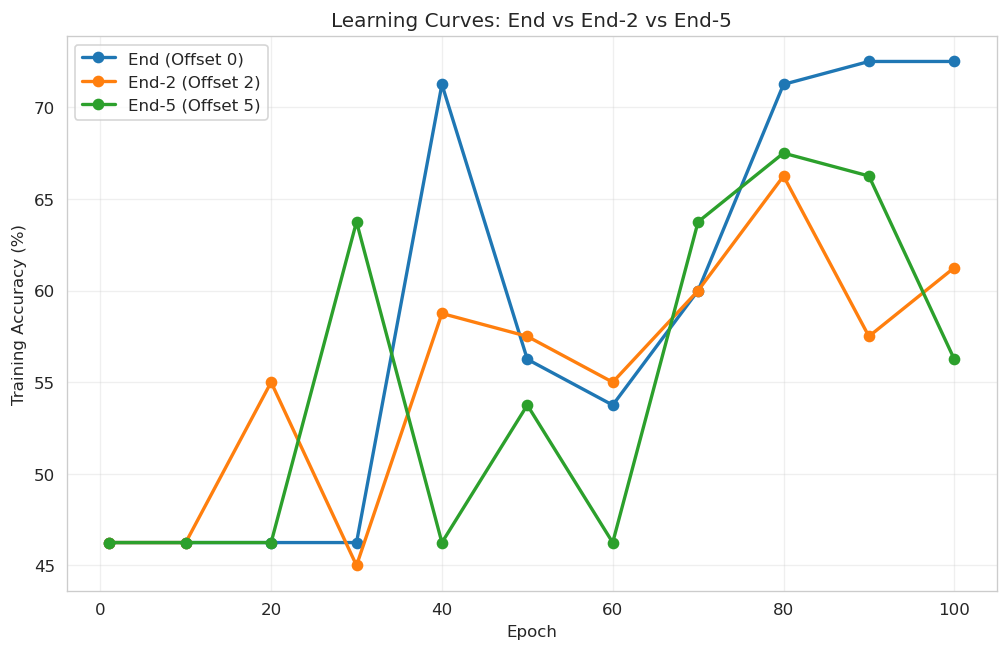

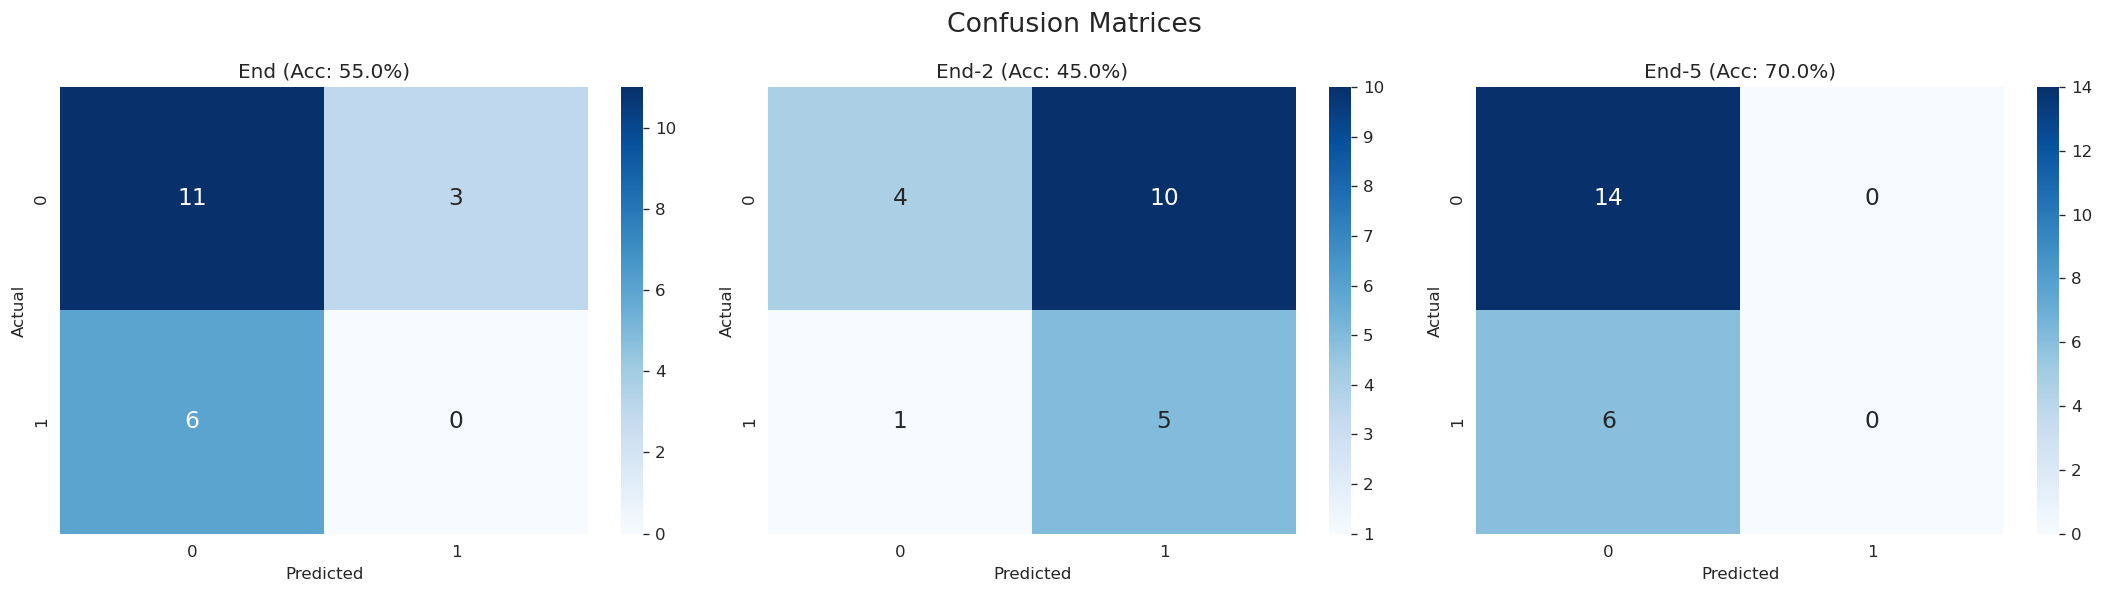

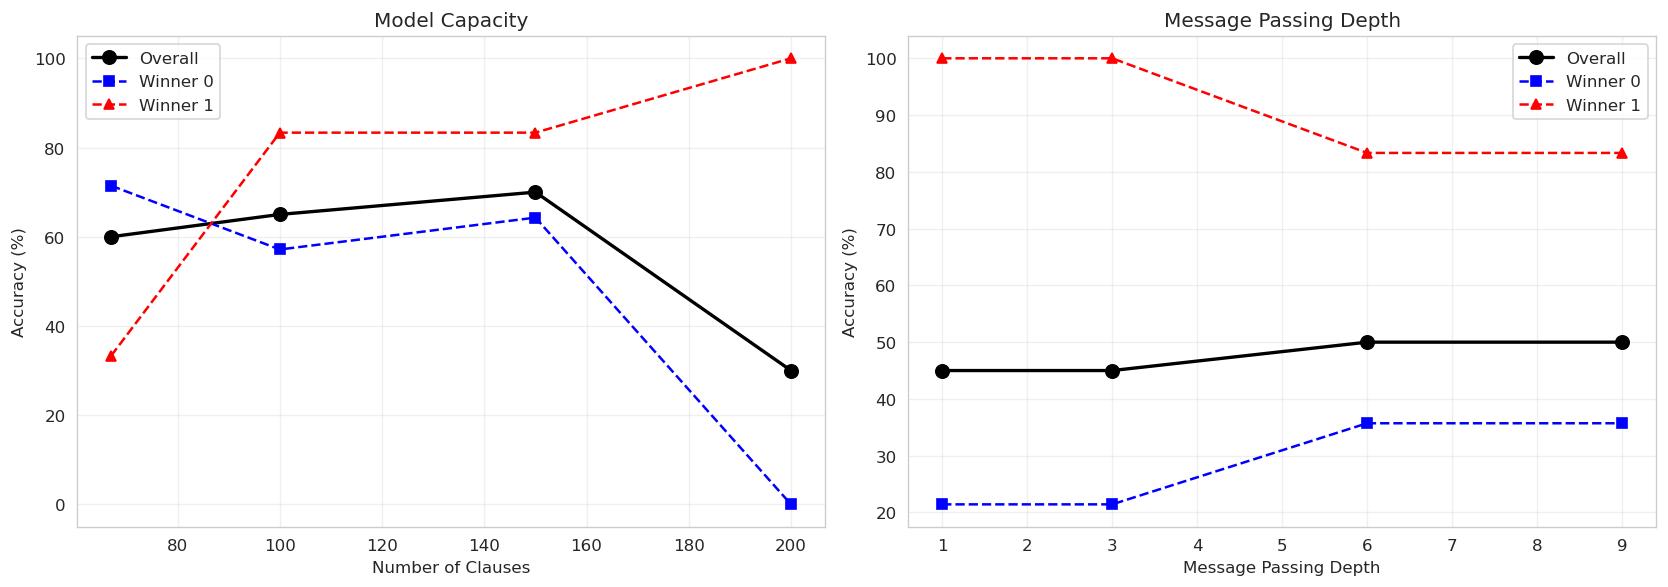

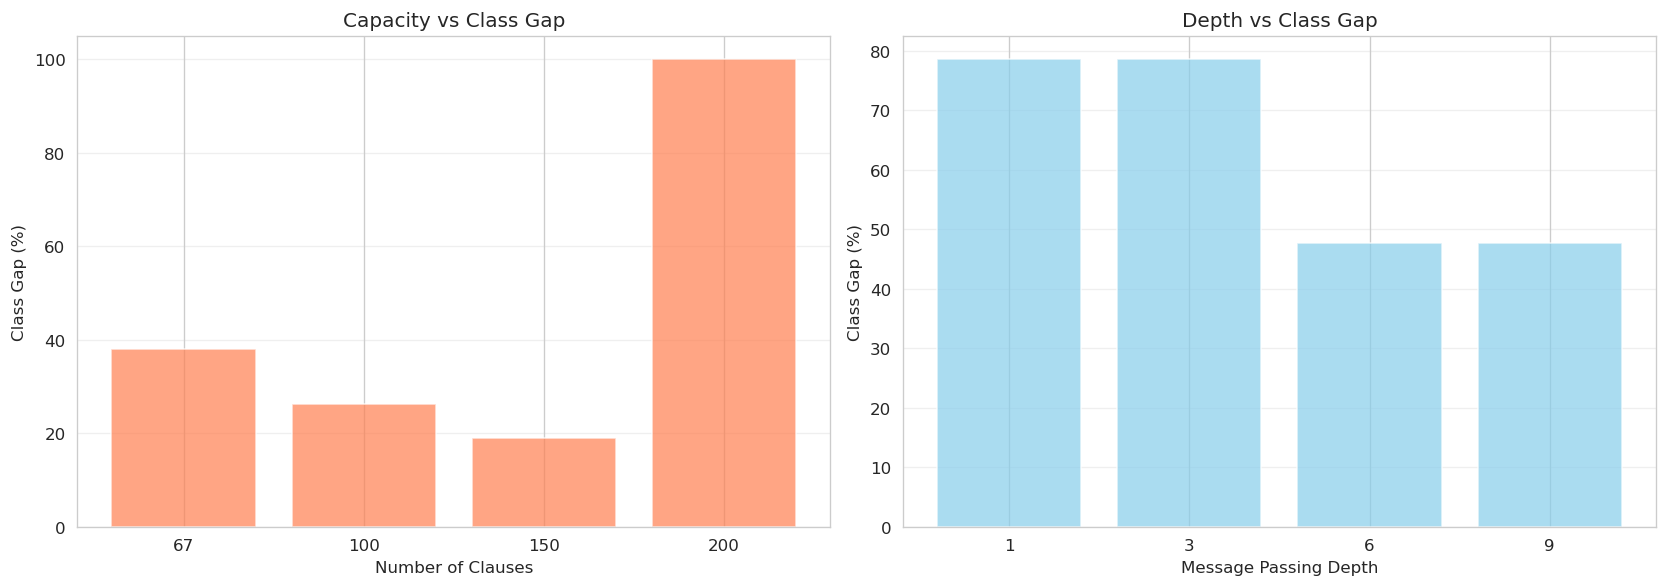


✓ All plots saved to runs/


In [43]:
# === SAVE PLOTS WITH CORRECT NAMES ===
if results_main:
    # Learning curves
    plt.figure(figsize=(10, 6))
    for res in results_main:
        epochs, accs = zip(*res['history']) if isinstance(res['history'][0], tuple) else (range(1, len(res['history'])+1), res['history'])
        label_map = {0: "End (Offset 0)", 2: "End-2 (Offset 2)", 5: "End-5 (Offset 5)"}
        plt.plot(epochs, accs, 'o-', label=label_map.get(res['offset'], f"Offset {res['offset']}"), linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy (%)")
    plt.title("Learning Curves: End vs End-2 vs End-5")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(RUNS_DIR, "3x3_learningcurve.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, res in enumerate(results_main):
        sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[i], annot_kws={'size': 14})
        label_map = {0: "End", 2: "End-2", 5: "End-5"}

        # Fix: Extract label separately to avoid nested f-strings
        label = label_map.get(res['offset'], f"Offset {res['offset']}")
        axes[i].set_title(f"{label} (Acc: {res['acc']:.1f}%)")

        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
    plt.suptitle("Confusion Matrices", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(RUNS_DIR, "3x3_confusionmatrix.png"), dpi=300, bbox_inches='tight')
    plt.show()

# Capacity and Depth plots
if 'results_capacity' in dir() and 'results_depth' in dir():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    df_cap = pd.DataFrame(results_capacity)
    ax1.plot(df_cap['clauses'], df_cap['overall'], 'o-', color='black', linewidth=2, markersize=8, label='Overall')
    ax1.plot(df_cap['clauses'], df_cap['winner0'], 's--', color='blue', linewidth=1.5, markersize=6, label='Winner 0')
    ax1.plot(df_cap['clauses'], df_cap['winner1'], '^--', color='red', linewidth=1.5, markersize=6, label='Winner 1')
    ax1.set_xlabel("Number of Clauses")
    ax1.set_ylabel("Accuracy (%)")
    ax1.set_title("Model Capacity")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    df_depth = pd.DataFrame(results_depth)
    ax2.plot(df_depth['depth'], df_depth['overall'], 'o-', color='black', linewidth=2, markersize=8, label='Overall')
    ax2.plot(df_depth['depth'], df_depth['winner0'], 's--', color='blue', linewidth=1.5, markersize=6, label='Winner 0')
    ax2.plot(df_depth['depth'], df_depth['winner1'], '^--', color='red', linewidth=1.5, markersize=6, label='Winner 1')
    ax2.set_xlabel("Message Passing Depth")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_title("Message Passing Depth")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(RUNS_DIR, "3x3_model_message.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Class gap plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.bar(df_cap['clauses'].astype(str), df_cap['gap'], color='coral', alpha=0.7)
    ax1.set_xlabel("Number of Clauses")
    ax1.set_ylabel("Class Gap (%)")
    ax1.set_title("Capacity vs Class Gap")
    ax1.grid(True, alpha=0.3, axis='y')

    ax2.bar(df_depth['depth'].astype(str), df_depth['gap'], color='skyblue', alpha=0.7)
    ax2.set_xlabel("Message Passing Depth")
    ax2.set_ylabel("Class Gap (%)")
    ax2.set_title("Depth vs Class Gap")
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(os.path.join(RUNS_DIR, "3x3_classgap_capacity_depth.png"), dpi=300, bbox_inches='tight')
    plt.show()

print(f"\n✓ All plots saved to {RUNS_DIR}/")